In [1]:
%pwd  #look at the current work dir
import sys
import pandas as pd
sys.path.append('src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = '/eris/scratch/jschubert/transformer/agency_blockwise_trained/rw_fitting.csv'
df = pd.read_csv(file)
df

,meta_rl_model,fitting_model,part_run,nll,bic,beta,alpha_free,alpha_forced,alpha_free_pos,alpha_free_neg,alpha_forced_pos,alpha_forced_neg
0,mask_policy_value_loss,Model_2alpha,0,159.793685,339.325124,3.613226,0.502476,0.173543,NaN,NaN,NaN,NaN
1,mask_policy_value_loss,Model_2alpha,1,95.010463,209.758680,9.100142,0.162298,0.164954,NaN,NaN,NaN,NaN
2,mask_policy_value_loss,Model_2alpha,2,157.376186,334.490125,13.278192,0.032467,0.086155,NaN,NaN,NaN,NaN
3,mask_policy_value_loss,Model_2alpha,3,128.260801,276.259356,7.394287,0.245927,0.123788,NaN,NaN,NaN,NaN
4,mask_policy_value_loss,Model_2alpha,4,108.879694,237.497142,6.515973,0.241996,0.172596,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
139,no_mask,Model_4alpha,19,40.685229,114.266715,21.766328,NaN,NaN,0.095025,0.035920,0.135730,0.022469
140,no_mask,Model_4alpha,20,40.803715,114.503686,16.277868,NaN,NaN,0.113089,0.012203,0.174741,0.191406
141,no_mask,Model_4alpha,21,39.615036,112.126329,20.100623,NaN,NaN,0.125814,0.035388,0.128368,0.053675
142,no_mask,Model_4alpha,22,39.212255,111.320766,14.485195,NaN,NaN,0.178575,0.068436,0.086130,0.125913


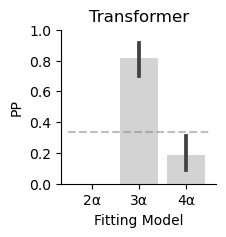

In [3]:
p = df[df['meta_rl_model'] == 'mask_policy_value_loss']
pivoted = p.pivot(index='part_run', columns='fitting_model', values='bic')

# calculate PP
bic_diff = pivoted.sub(pivoted.min(axis=1), axis=0)
unnormalized_pp = np.exp(-0.5 * bic_diff)
normalized_pp = unnormalized_pp.div(unnormalized_pp.sum(axis=1), axis=0)

# convert to plotting format
reset = normalized_pp.reset_index()
reset.head()
melt = reset.melt(id_vars='part_run', 
            value_vars=reset.columns[1:],
            var_name='fitting_model',
            value_name='bic')


plt.figure(figsize=(2,2))
plt.ylim(0, 1)

sns.barplot(data=melt, x='fitting_model', y='bic', color='lightgrey')
sns.despine()

# change labels to 2α 3α 4α
labels = ['2α', '3α', '4α']
plt.xticks(np.arange(3), labels)
plt.xlabel('Fitting Model')
plt.ylabel('PP')
plt.title('Transformer')

plt.hlines(y=melt.mean(numeric_only=True)['bic'], xmin=-0.5, xmax=2.5, linestyle='--', alpha=0.5, color='grey')


In [6]:
fit = pd.concat([normalized_pp.mean().round(2), normalized_pp.sem().round(3)], axis=1, keys=['mean', 'sem'])

fit.loc['1/N', 'mean'] = melt.mean(numeric_only=True)['bic']
fit.round(2)

,mean,sem
fitting_model,,
Model_2alpha,0.00,0.00
Model_3alpha,0.81,0.06
Model_4alpha,0.19,0.06
1/N,0.33,NaN


Text(0.5, 1.0, 'Transfomer')

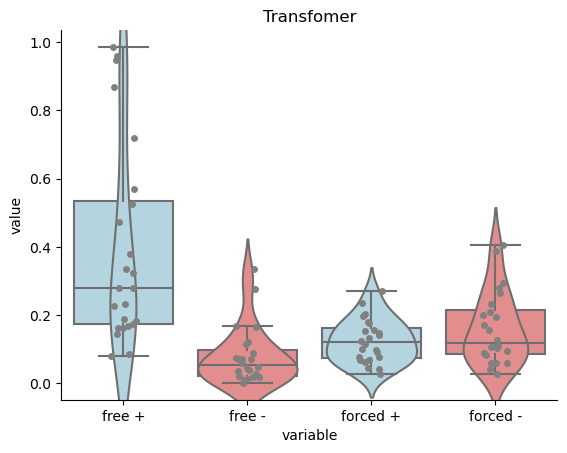

In [14]:

pl = p[p.fitting_model == 'Model_4alpha']

plot_df = pd.DataFrame({'free +': pl.alpha_free_pos, 
                        'free -': pl.alpha_free_neg, 
                        'forced +': pl.alpha_forced_pos, 
                        'forced -': pl.alpha_forced_neg})

plt_df = plot_df.melt()

palette = ['lightblue', 'lightcoral', 'lightblue', 'lightcoral']

sns.violinplot(x="variable", y="value", data=plt_df, palette=palette, inner=None)
sns.stripplot(x="variable", y="value", data=plt_df, jitter=True, color='grey')
sns.boxplot(x="variable", y="value", data=plt_df, palette=palette, showfliers=False)
sns.despine()


plt.title('Transfomer')

In [ ]:
plot_df.mean()

In [26]:
import scipy.stats as stats

plot_df = plot_df.dropna()
res, pvalue = stats.ttest_rel(plot_df['free +'], plot_df['free -'])
res1, pvalue1 = stats.ttest_rel(plot_df['forced +'], plot_df['forced -'])

print(f'pvalue for post-free difference: {pvalue:.8f}')
print(f'pvalue for post-forced difference: {pvalue1:.4f}')

pvalue for post-free difference: 0.00000171
pvalue for post-forced difference: 0.1622


Text(0.5, 1.0, 'Meta-RL')

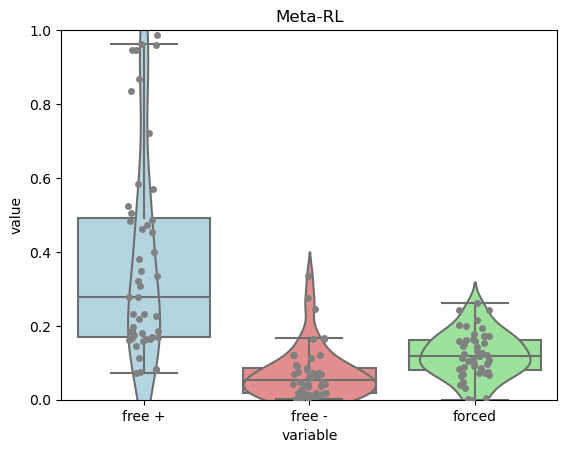

In [6]:
plot_df = pd.DataFrame({'free +': p.alpha_free_pos, 
                        'free -': p.alpha_free_neg, 
                        'forced': p.alpha_forced})

plt_df = plot_df.melt()

palette = ['lightblue', 'lightcoral', 'lightgreen']

sns.violinplot(x="variable", y="value", data=plt_df, palette=palette, inner=None)
sns.stripplot(x="variable", y="value", data=plt_df, jitter=True, color='grey')
sns.boxplot(x="variable", y="value", data=plt_df, palette=palette, showfliers=False)

plt.ylim(0, 1)

plt.title('Meta-RL')


In [32]:
plot_df.mean()

free +    0.378459
free -    0.071308
forced    0.122144
dtype: float64